In [1]:
import sys
sys.path.append('../scripts/')

from azure.identity import DefaultAzureCredential
from azure.storage.blob import BlobServiceClient
import json
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os

from bbdl_utils import fetch_and_convert, plot_series, plot_two_series

In [2]:
# 1. Load .env into environment
load_dotenv()  

# 2. Read the connection string
AZURE_CONN_STR = os.getenv("AZURE_CONN_STR")
if not AZURE_CONN_STR:
    raise RuntimeError("Missing AZURE_CONN_STR—make sure .env is present and loaded")

# 3. Create the client
service = BlobServiceClient.from_connection_string(AZURE_CONN_STR)

In [3]:
# 1) Pull in the three series
etf_shares = fetch_and_convert(service,
    data_type="EQY_SH_OUT", ticker="NVDL US Equity")
etf_nav    = fetch_and_convert(service,
    data_type="PX_LAST",    ticker="NVDL US Equity")
nvda_price = fetch_and_convert(service,
    data_type="PX_LAST",    ticker="NVDA US Equity")

# 2) Align on dates
df = pd.DataFrame({
    "etf_shares": etf_shares,    # in MM shares
    "etf_nav":    etf_nav,       # USD per ETF share
    "nvda_price": nvda_price     # USD per NVDA share
}).dropna()

0.8514722437667235


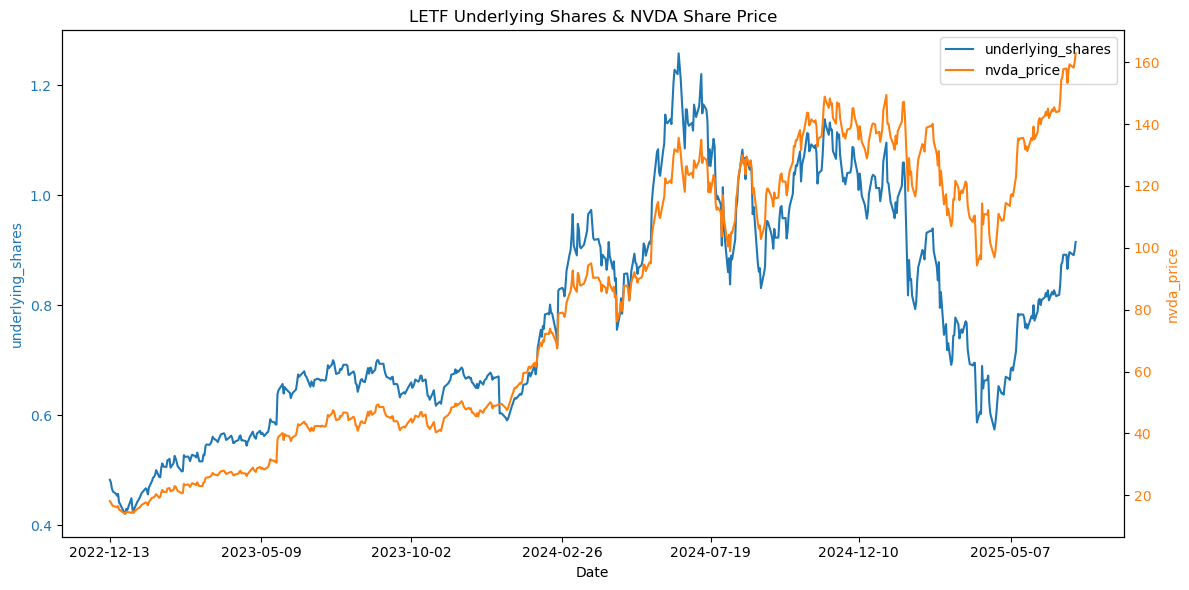

In [16]:
# 3) Compute underlying shares held each day
L = 2

df["underlying_shares"] = (L * df["etf_nav"]) / df["nvda_price"]
df["underlying_shares"].name = "Underlying Shares Held (MM)"

df["underlying_shares_change"] = df["underlying_shares"].diff()
df["underlying_shares_change"].name = "Rebalanced Shares Held (MM)"

df["nvda_price_diff"] = df["nvda_price"].diff()
df["nvda_price_diff"].name = "Daily Change in NVDA Share Price"

# 4) Plot the underlying shares rebalancing vs NVDA stock price
price_corr = df["nvda_price"].corr(df["underlying_shares"])       # Pearson by default
print(price_corr)
plot_two_series(df["underlying_shares"], df["nvda_price"], ["LETF Underlying Shares", "NVDA Share Price"])



0.9736466654104915


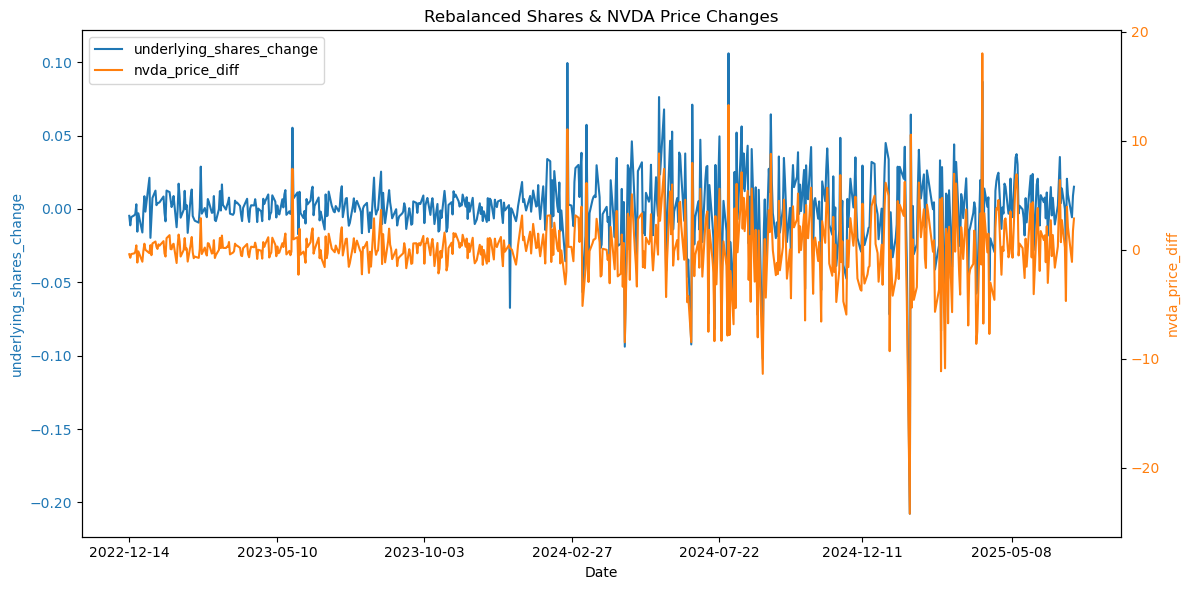

In [13]:
# 5) Plot the daily change
corr = df["nvda_price_diff"].corr(df["underlying_shares_change"])       # Pearson by default
print(corr)
plot_two_series(df["underlying_shares_change"], df["nvda_price_diff"], ["Rebalanced Shares", "NVDA Price Changes"])


0.973469929880536


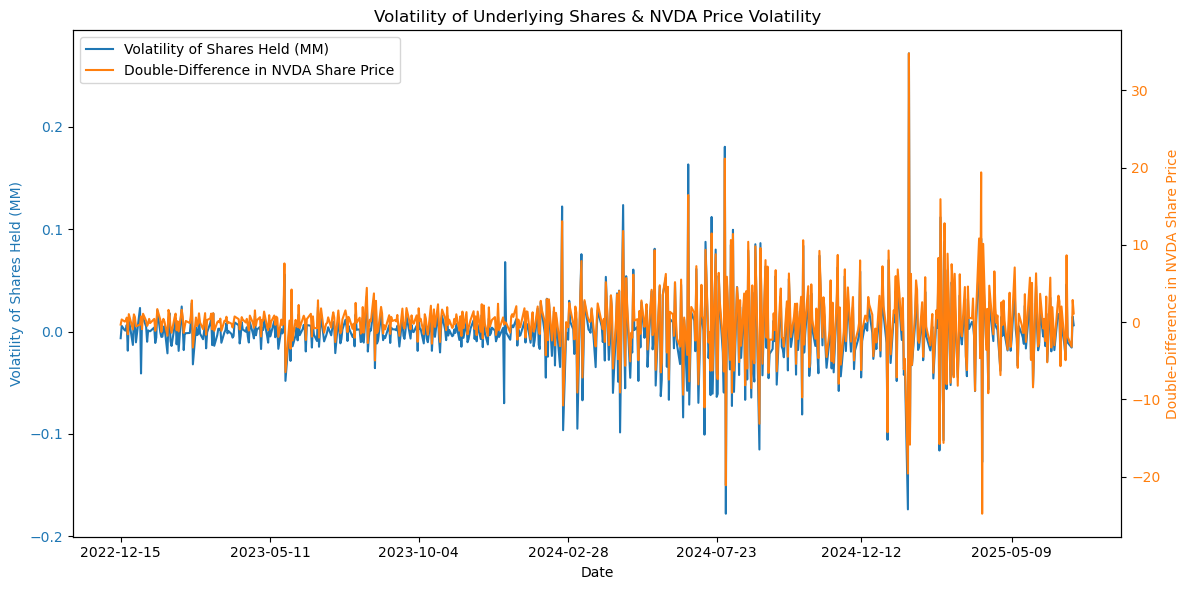

In [17]:
# 6) Plot the underling_shares_change against the volatility (ie second derivative of NVDA)
df["nvda_price_vol"] = df["nvda_price_diff"].diff()
df["nvda_price_vol"].name = "Double-Difference in NVDA Share Price"

df["underlying_shares_vol"] = df["underlying_shares_change"].diff()
df["underlying_shares_vol"].name = "Volatility of Shares Held (MM)"

vol_corr = df["nvda_price_vol"].corr(df["underlying_shares_vol"])       # Pearson by default
print(vol_corr)
plot_two_series(df["underlying_shares_vol"], df["nvda_price_vol"], ["Volatility of Underlying Shares", "NVDA Price Volatility"])